# Punto 3: Optimización 3D de Estructura Cristalina NdFe₁₂ con Ti

## Objetivo

Encontrar la configuración óptima de **8 átomos de Titanio (Ti)** que sustituyen a átomos de Hierro (Fe) en la estructura cristalina de NdFe₁₂, minimizando la energía del sistema mediante el potencial de Morse.

### Sistema 3D:
- **N posiciones candidatas**: Fe o Ti (coordenadas cristalográficas)
- **16 átomos de Nd**: Fijos (tierras raras)
- **8 átomos de Ti**: A optimizar
- **Total**: (N-8) Fe + 8 Ti + 16 Nd átomos

### Espacio de búsqueda:
$$\\binom{N}{8} \\text{ configuraciones posibles}$$

### Método:
- **Simulated Annealing** con enfriamiento logarítmico: $T(t) = \\frac{c}{\\log(t + t_0)}$
- **64 runs independientes** × 1,000,000 iteraciones
- **Paralelización** con joblib para acelerar cálculos
- **Optimización Numba** (@njit) para cálculo incremental de energía (speedup ~25-1000×)

---
## Sección 1: Setup e Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import sys
import time
from pathlib import Path

# Agregar path para imports de módulos
project_root = Path.cwd().parent
src_path = project_root / 'src' / 'punto3'
sys.path.insert(0, str(src_path))

print(f"Proyecto: {project_root}")
print(f"Módulos punto3: {src_path}")
print("✓ Imports completados")

Proyecto: /home/riemannintegrable/universidad/cadenas_de_markov/parcial2
Módulos punto3: /home/riemannintegrable/universidad/cadenas_de_markov/parcial2/src/punto3
✓ Imports completados


In [2]:
# Imports de módulos personalizados
from morse.potential_numba_3d import (
    preparar_morse_params_array,
    get_morse_params_by_names
)
from grid.config_utils_3d import (
    crear_configuracion_inicial_3d,
    get_Ti_positions_3d,
    get_Fe_positions_3d,
    get_Nd_positions_3d
)
from grid.energy_numba_3d import (
    compute_total_energy_3d,
    validate_delta_E_3d
)
from optimization.sa_numba_3d import simulated_annealing_logarithmic_3d
from optimization.parallel_runs_3d import (
    ejecutar_multiples_runs_3d,
    get_best_run,
    get_run_statistics,
    filter_top_runs
)
from analysis.spatial_analysis_numba_3d import (
    analizar_patron_espacial_3d,
    interpretar_patron_3d
)
from visualization.plotting_3d import (
    plot_configuration_3d_plotly,
    plot_projections_2d,
    plot_energy_evolution,
    plot_spatial_metrics_3d,
    plot_multiple_runs_comparison_3d
)

print("✓ Módulos personalizados importados correctamente")

✓ Módulos personalizados importados correctamente


### Cargar Coordenadas Cristalinas

Las coordenadas fueron extraídas del notebook `cristal.ipynb` (corregidas a 96 Fe exactos).

In [3]:
# Coordenadas de átomos de Fe (posiciones candidatas para Fe/Ti)
# IMPORTANTE: Actualiza este string con las coordenadas correctas de tu estructura cristalina
Fe_coords_text = """9.355852 10.585328 1.113263
5.369959 1.369285 8.739198
1.304919 5.423740 8.955198
4.164790 6.449703 0.747567
2.225767 10.598074 8.895287
0.888913 7.820260 8.169839
3.492882 8.931727 7.433415
8.735347 4.612294 3.103044
11.849883 2.893958 9.572409
8.676605 0.233685 7.638947
7.610978 11.605369 3.265871
8.943925 4.975204 9.931463
8.080369 10.667493 6.884033
4.442836 4.082240 0.769031
5.927012 8.404075 0.660945
11.090606 9.158117 8.844588
5.458155 8.282210 9.580428
11.818225 0.090419 6.490132
10.851695 8.164268 0.885078
7.604208 6.604095 2.269189
7.551071 0.283781 0.331972
6.542910 0.021318 2.772652
2.286462 10.450918 0.864769
5.561915 3.934575 9.372184
10.404992 0.994529 1.716812
8.134795 8.468424 8.135201
5.787799 1.863687 0.427816
10.021202 1.627433 9.324877
8.286005 3.681089 0.924556
0.666241 3.368412 1.137830
4.491507 11.730712 6.963753
11.645045 5.921111 8.144807
7.533877 0.312095 9.830940
8.303342 3.984356 7.466048
1.171240 6.711089 1.285717
11.825413 10.991988 2.999415
4.110961 6.947420 8.387238
1.838934 2.109013 7.931020
3.115584 3.576601 9.108309
5.568203 7.224661 2.860849
4.297788 11.150660 2.109927
0.652759 11.121213 3.052607
2.945070 0.330353 3.718641
0.357578 0.843476 0.874817
8.473670 11.015759 9.032771
4.617175 11.769630 9.691877
11.963572 5.381976 0.339757
2.554167 3.306161 3.171555
8.615976 6.191542 6.677277
10.458020 3.725810 1.735437
2.505694 8.428964 3.074532
5.883702 10.166322 8.014315
0.060642 10.782486 7.081346
6.150876 5.844691 7.630240
2.517698 1.714604 0.086137
11.922994 11.510980 6.720062
0.798926 2.253428 9.990988
11.116281 7.730314 3.072559
7.853566 8.849633 3.046983
8.312888 8.094529 0.451763
11.633877 0.910654 3.543125
0.263465 0.555397 5.894605
9.168634 6.000330 0.740211
11.950787 8.617264 6.042968
5.030916 2.454327 2.832792
2.272961 0.006817 9.447623
4.804672 0.031607 6.634810
0.407372 11.569006 0.136591
8.694965 1.472785 3.250801
3.799746 2.695216 6.991908
11.851259 6.004944 5.216196
6.494832 10.348021 1.701906
0.096452 3.752499 3.306831
0.441470 3.955366 7.450495
0.419311 8.811383 0.394205
7.513119 2.713569 9.090149
11.678488 4.192737 3.730411
0.012339 0.186240 9.561188
6.491888 5.457928 0.078655
9.068735 11.940016 5.010867
10.927141 2.814795 7.486171
2.988473 5.809583 6.796071
10.570495 11.986366 9.001430
0.525780 9.366159 9.904863
0.268121 6.267514 4.327448
6.116502 5.009969 2.580557
0.287100 8.680000 3.192427
7.449651 6.806950 9.828668
11.827459 2.261272 0.287344
3.517229 0.321125 1.545865
3.341669 5.997731 2.967428
5.847078 3.639110 6.846499
0.076608 8.975018 5.755421
8.456252 0.009384 4.934394
0.773535 0.779895 3.296252
9.557307 7.849922 9.739059"""

Fe_candidate_positions = np.array([list(map(float, line.split())) for line in Fe_coords_text.strip().split('\n')])
print(f"Fe candidate positions: {Fe_candidate_positions.shape}")

# Coordenadas de átomos de Nd (16 posiciones fijas)
Nd_coords_text = """1.906213 2.055030 5.025076
1.972537 4.763518 4.907878
2.079941 7.424727 5.066227
2.013595 10.057875 4.982238
4.695176 2.012727 5.090741
4.667139 4.675904 5.029549
4.591431 7.337889 4.993691
4.607595 10.020975 4.978502
7.429381 2.065083 5.035214
7.314779 4.576909 5.053848
7.347388 7.277426 4.978411
7.256977 10.042528 4.938427
10.060516 1.939263 4.998550
9.909308 4.700037 5.018970
9.900065 7.333659 5.099287
10.076874 9.976908 5.098720"""

Nd_positions = np.array([list(map(float, line.split())) for line in Nd_coords_text.strip().split('\n')])
print(f"Nd positions: {Nd_positions.shape}")

# Validación dinámica
n_Fe = len(Fe_candidate_positions)
n_Nd = len(Nd_positions)
assert n_Nd == 16, f"ERROR: Se esperan 16 posiciones de Nd, pero se encontraron {n_Nd}"
assert n_Fe >= 8, f"ERROR: Se necesitan al menos 8 posiciones candidatas para colocar 8 Ti"

print(f"\n✓ Coordenadas cargadas correctamente:")
print(f"  - {n_Fe} posiciones candidatas (Fe/Ti)")
print(f"  - {n_Nd} posiciones fijas (Nd)")
print(f"  - Total sistema: {n_Fe + n_Nd} átomos ({n_Fe - 8} Fe + 8 Ti + {n_Nd} Nd)")

# Advertencia si no son 96
if n_Fe != 96:
    print(f"\n⚠️  ADVERTENCIA: Se esperaban 96 posiciones de Fe, pero se encontraron {n_Fe}")
    print(f"   El sistema funcionará con {n_Fe} posiciones, pero verifica que las coordenadas sean correctas")

Fe candidate positions: (96, 3)
Nd positions: (16, 3)

✓ Coordenadas cargadas correctamente:
  - 96 posiciones candidatas (Fe/Ti)
  - 16 posiciones fijas (Nd)
  - Total sistema: 112 átomos (88 Fe + 8 Ti + 16 Nd)


---
## Sección 2: Visualización de Estructura Cristalina Inicial

In [4]:
# Visualización 3D interactiva de la estructura cristalina completa
fig = go.Figure()

# Añadir átomos de Fe candidatos (azul claro)
fig.add_trace(go.Scatter3d(
    x=Fe_candidate_positions[:, 0],
    y=Fe_candidate_positions[:, 1],
    z=Fe_candidate_positions[:, 2],
    mode='markers',
    name=f'Fe candidatos (n={len(Fe_candidate_positions)})',
    marker=dict(
        size=5,
        color='lightblue',
        opacity=0.7,
        line=dict(color='navy', width=1)
    ),
    hovertemplate='<b>Fe</b><br>X: %{x:.3f} Å<br>Y: %{y:.3f} Å<br>Z: %{z:.3f} Å<extra></extra>'
))

# Añadir átomos de Nd (dorado)
fig.add_trace(go.Scatter3d(
    x=Nd_positions[:, 0],
    y=Nd_positions[:, 1],
    z=Nd_positions[:, 2],
    mode='markers',
    name=f'Nd (n={len(Nd_positions)})',
    marker=dict(
        size=12,
        color='gold',
        opacity=0.95,
        line=dict(color='orange', width=2)
    ),
    hovertemplate='<b>Nd</b><br>X: %{x:.3f} Å<br>Y: %{y:.3f} Å<br>Z: %{z:.3f} Å<extra></extra>'
))

# Configurar layout
fig.update_layout(
    title=dict(
        text='Estructura Cristalina 3D: NdFe₁₂ (Supercelda 2×2×1)',
        font=dict(size=18, family='Arial')
    ),
    scene=dict(
        xaxis=dict(title='X (Å)', backgroundcolor='white', gridcolor='lightgray'),
        yaxis=dict(title='Y (Å)', backgroundcolor='white', gridcolor='lightgray'),
        zaxis=dict(title='Z (Å)', backgroundcolor='white', gridcolor='lightgray'),
        aspectmode='cube'
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    hovermode='closest'
)

fig.show()

# Guardar imagen estática para el reporte (requiere kaleido: pip install kaleido)
try:
    fig.write_image('../report/images/punto3_estructura_cristalina.png', width=1920, height=1440, scale=2)
    print("✓ Imagen guardada: punto3_estructura_cristalina.png")
except Exception as e:
    print(f"⚠️  No se pudo guardar la imagen Plotly: {e}")
    print("   Instala kaleido: pip install kaleido")

# Estadísticas de la estructura
print("\n📊 Estadísticas de la Estructura Cristalina:")
print(f"   Rango X: [{Fe_candidate_positions[:, 0].min():.3f}, {Fe_candidate_positions[:, 0].max():.3f}] Å")
print(f"   Rango Y: [{Fe_candidate_positions[:, 1].min():.3f}, {Fe_candidate_positions[:, 1].max():.3f}] Å")
print(f"   Rango Z: [{Fe_candidate_positions[:, 2].min():.3f}, {Fe_candidate_positions[:, 2].max():.3f}] Å")

# Centroide del sistema
all_positions_temp = np.vstack([Fe_candidate_positions, Nd_positions])
centroid = all_positions_temp.mean(axis=0)
print(f"   Centroide: ({centroid[0]:.3f}, {centroid[1]:.3f}, {centroid[2]:.3f}) Å")

⚠️  No se pudo guardar la imagen Plotly: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome


   Instala kaleido: pip install kaleido

📊 Estadísticas de la Estructura Cristalina:
   Rango X: [0.012, 11.964] Å
   Rango Y: [0.007, 11.986] Å
   Rango Z: [0.079, 9.991] Å
   Centroide: (5.940, 5.713, 5.030) Å


### Tabla Resumen del Sistema

In [5]:
# Crear tabla resumen
import math

n_Fe_candidates = len(Fe_candidate_positions)
summary_data = {
    'Tipo de Átomo': ['Fe (candidatos)', 'Ti (a optimizar)', 'Nd (fijos)', 'Total'],
    'Cantidad': [n_Fe_candidates, 8, 16, n_Fe_candidates + 16],
    'Estado': ['Variable', 'Variable', 'Fijo', '-'],
    'Descripción': [
        'Posiciones candidatas para Fe o Ti',
        'Sustituyen a 8 Fe (optimización)',
        'Tierras raras (no cambian)',
        f'{n_Fe_candidates - 8} Fe + 8 Ti + 16 Nd'
    ]
}

df_summary = pd.DataFrame(summary_data)
display(df_summary)

print(f"\n🎯 Espacio de búsqueda: C({n_Fe_candidates},8) = {math.comb(n_Fe_candidates, 8):.2e} configuraciones posibles")

,Tipo de Átomo,Cantidad,Estado,Descripción
0,Fe (candidatos),96,Variable,Posiciones candidatas para Fe o Ti
1,Ti (a optimizar),8,Variable,Sustituyen a 8 Fe (optimización)
2,Nd (fijos),16,Fijo,Tierras raras (no cambian)
3,Total,112,-,88 Fe + 8 Ti + 16 Nd



🎯 Espacio de búsqueda: C(96,8) = 1.33e+11 configuraciones posibles


---
## Sección 3: Configuración Inicial Aleatoria

In [6]:
# Crear configuración inicial con seed fijo para reproducibilidad
SEED_INICIAL = 42

atom_types_init, all_positions_init, Ti_indices_init, Fe_indices_init = crear_configuracion_inicial_3d(
    Fe_candidate_positions,
    Nd_positions,
    seed=SEED_INICIAL
)

print(f"✓ Configuración inicial creada (seed={SEED_INICIAL})")
print(f"  - Tipos atómicos: {atom_types_init.shape}")
print(f"  - Posiciones totales: {all_positions_init.shape}")
print(f"  - Índices Ti: {Ti_indices_init}")
print(f"  - Número de Fe: {len(Fe_indices_init)}")
print(f"  - Número de Ti: {len(Ti_indices_init)}")
print(f"  - Número de Nd: 16")

✓ Configuración inicial creada (seed=42)
  - Tipos atómicos: (112,)
  - Posiciones totales: (112, 3)
  - Índices Ti: [33 42 69 73 77 79 80 94]
  - Número de Fe: 88
  - Número de Ti: 8
  - Número de Nd: 16


In [7]:
# Preparar parámetros del potencial de Morse
morse_params_array = preparar_morse_params_array()
print("✓ Parámetros de Morse preparados")
print(f"  Shape: {morse_params_array.shape} (tipos_i, tipos_j, [D0, alpha, r0])")

# Mostrar algunos parámetros
print("\n📋 Parámetros de Morse para pares atómicos:")
pares = [('Fe', 'Fe'), ('Fe', 'Nd'), ('Fe', 'Ti'), ('Nd', 'Nd'), ('Nd', 'Ti'), ('Ti', 'Ti')]
for tipo1, tipo2 in pares:
    D0, alpha, r0 = get_morse_params_by_names(tipo1, tipo2)
    print(f"  {tipo1}-{tipo2:2s}: D₀={D0:.4f}, α={alpha:.4f}, r₀={r0:.4f}")

✓ Parámetros de Morse preparados
  Shape: (3, 3, 3) (tipos_i, tipos_j, [D0, alpha, r0])

📋 Parámetros de Morse para pares atómicos:
  Fe-Fe: D₀=0.7640, α=1.5995, r₀=2.7361
  Fe-Nd: D₀=0.6036, α=1.6458, r₀=3.1880
  Fe-Ti: D₀=0.8162, α=1.4480, r₀=2.9140
  Nd-Nd: D₀=0.3120, α=0.9450, r₀=4.0920
  Nd-Ti: D₀=0.4964, α=1.4401, r₀=3.4309
  Ti-Ti: D₀=0.6540, α=1.2118, r₀=3.3476


In [8]:
# Calcular energía inicial
energia_inicial = compute_total_energy_3d(atom_types_init, all_positions_init, morse_params_array)
print(f"\n⚡ Energía inicial (configuración aleatoria): {energia_inicial:.6f}")


⚡ Energía inicial (configuración aleatoria): -29.229974


In [9]:
# Visualizar configuración inicial con Ti destacados
fig_init = plot_configuration_3d_plotly(
    Fe_candidate_positions,
    Nd_positions,
    Ti_indices_init,
    energia_inicial,
    title="Configuración Inicial (Aleatoria)"
)
fig_init.show()

# Guardar imagen estática
try:
    fig_init.write_image('../report/images/punto3_configuracion_inicial.png', width=1920, height=1440, scale=2)
    print("✓ Imagen guardada: punto3_configuracion_inicial.png")
except Exception as e:
    print(f"⚠️  No se pudo guardar la imagen: {e}")

print("\n✓ Configuración inicial visualizada (8 Ti en rojo, posiciones aleatorias)")

⚠️  No se pudo guardar la imagen: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



✓ Configuración inicial visualizada (8 Ti en rojo, posiciones aleatorias)


---
## Sección 4: Optimización con Simulated Annealing

### Parámetros del Algoritmo

**Enfriamiento Logarítmico:** $T(t) = \frac{c}{\log(t + t_0)}$

- **c = 100**: Constante de enfriamiento
- **t₀ = 10**: Offset temporal
- **T(0)** = c/ln(t₀) ≈ 43.4 (temperatura inicial)
- **Iteraciones**: 1,000,000 por run
- **Runs independientes**: 64 (con paralelización)

Este esquema de enfriamiento garantiza **convergencia global** al óptimo (Teorema de Hajek, 1988).

In [10]:
# Parámetros de optimización
N_RUNS = 64
MAX_ITERATIONS = 10_000_000
C_COOLING = 20
T0_COOLING = 2
N_JOBS = -1  # Usar todos los cores disponibles

print("🔧 Parámetros de Simulated Annealing:")
print(f"  - Runs independientes: {N_RUNS}")
print(f"  - Iteraciones por run: {MAX_ITERATIONS:,}")
print(f"  - Enfriamiento: T(t) = {C_COOLING}/log(t + {T0_COOLING})")
print(f"  - Temperatura inicial: {C_COOLING / np.log(T0_COOLING):.2f}")
print(f"  - Paralelización: {N_JOBS} (todos los cores)")
print(f"\n⏱️  Tiempo estimado: ~10-20 minutos (dependiendo de CPU)")

🔧 Parámetros de Simulated Annealing:
  - Runs independientes: 64
  - Iteraciones por run: 10,000,000
  - Enfriamiento: T(t) = 20/log(t + 2)
  - Temperatura inicial: 28.85
  - Paralelización: -1 (todos los cores)

⏱️  Tiempo estimado: ~10-20 minutos (dependiendo de CPU)


In [11]:
# Ejecutar optimización con múltiples runs en paralelo
print(f"\n🚀 Iniciando optimización: {N_RUNS} runs × {MAX_ITERATIONS:,} iteraciones...\n")
start_time = time.time()

resultados = ejecutar_multiples_runs_3d(
    n_runs=N_RUNS,
    Fe_candidate_positions=Fe_candidate_positions,
    Nd_positions=Nd_positions,
    c=C_COOLING,
    t0=T0_COOLING,
    max_iterations=MAX_ITERATIONS,
    morse_params_array=morse_params_array,
    n_jobs=N_JOBS,
    verbose=10
)

elapsed_time = time.time() - start_time
print(f"\n✓ Optimización completada en {elapsed_time:.2f} segundos ({elapsed_time/60:.2f} minutos)")
print(f"  Throughput: {N_RUNS * MAX_ITERATIONS / elapsed_time:.2e} iteraciones/segundo")


🚀 Iniciando optimización: 64 runs × 10,000,000 iteraciones...

Ejecutando 64 runs de Simulated Annealing 3D en paralelo...
  Parámetros: c=20, t₀=2, max_iter=10,000,000
  Jobs paralelos: -1 (todos los cores)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  40 out of  64 | elapsed:  4.1min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  47 out of  64 | elapsed:  4.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  54 out of  64 | elapsed:  5.2min remaining:   58.2s
[Parallel(n_jobs=-1)]: Done  61 out of  64 | elapsed:  5.3min remaining:   15.8s



✓ Completados 64 runs

Estadísticas:
  Mejor energía: -55.981237
  Peor energía: -55.594999
  Media: -55.891624
  Desv. estándar: 0.089732
  Mejora promedio: 48.99%
  Tiempo promedio por run: 78.40 s (1.31 min)

✓ Optimización completada en 323.41 segundos (5.39 minutos)
  Throughput: 1.98e+06 iteraciones/segundo


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  5.4min finished


---
## Sección 5: Análisis de Resultados

In [12]:
# Recargar módulos para obtener la versión actualizada
import importlib
import optimization.parallel_runs_3d
importlib.reload(optimization.parallel_runs_3d)
from optimization.parallel_runs_3d import get_run_statistics

# Estadísticas agregadas de todos los runs
stats = get_run_statistics(resultados)

print("\n📊 Estadísticas de Todos los Runs:")
print(f"  Energía final:")
print(f"    - Mejor (mínima): {stats['energia_final_min']:.6f}")
print(f"    - Peor (máxima):  {stats['energia_final_max']:.6f}")
print(f"    - Media:          {stats['energia_final_mean']:.6f}")
print(f"    - Desv. Std:      {stats['energia_final_std']:.6f}")
print(f"\n  Mejora relativa (%):")
print(f"    - Mejor:  {stats['mejora_relativa_max']:.2f}%")
print(f"    - Peor:   {stats['mejora_relativa_min']:.2f}%")
print(f"    - Media:  {stats['mejora_relativa_mean']:.2f}%")
print(f"\n  Tasa de aceptación (%):")
print(f"    - Media: {stats['acceptance_rate_mean']:.2f}%")
print(f"    - Rango: [{stats['acceptance_rate_min']:.2f}%, {stats['acceptance_rate_max']:.2f}%]")


📊 Estadísticas de Todos los Runs:
  Energía final:
    - Mejor (mínima): -55.981237
    - Peor (máxima):  -55.594999
    - Media:          -55.891624
    - Desv. Std:      0.089732

  Mejora relativa (%):
    - Mejor:  103.52%
    - Peor:   13.72%
    - Media:  48.99%

  Tasa de aceptación (%):
    - Media: 0.50%
    - Rango: [0.50%, 0.50%]


In [13]:
# Recargar para obtener get_best_run actualizado
from optimization.parallel_runs_3d import get_best_run

# Obtener el mejor run
best_run = get_best_run(resultados)

print(f"\n🏆 Mejor Configuración Encontrada:")
print(f"  Run ID: {best_run['run_id']}")
print(f"  Energía inicial:  {best_run['energia_inicial']:.6f}")
print(f"  Energía final:    {best_run['energia_final']:.6f}")
print(f"  Mejora absoluta:  {best_run['energia_inicial'] - best_run['energia_final']:.6f}")
print(f"  Mejora relativa:  {best_run['mejora_relativa'] * 100:.2f}%")
print(f"  Iteración óptima: {best_run['iterations_to_best']:,}")
print(f"  Tasa aceptación:  {best_run['acceptance_rate']:.2f}%")


🏆 Mejor Configuración Encontrada:
  Run ID: 22
  Energía inicial:  -36.521201
  Energía final:    -55.981237
  Mejora absoluta:  19.460036
  Mejora relativa:  53.28%
  Iteración óptima: 1,041,867
  Tasa aceptación:  0.50%


In [14]:
# Top 10 mejores runs
top_runs = filter_top_runs(resultados, top_n=10)

# Crear tabla comparativa
top_df = pd.DataFrame([
    {
        'Rank': i + 1,
        'Run ID': r['run_id'],
        'Energía Final': f"{r['energia_final']:.6f}",
        'Mejora (%)': f"{r['mejora_relativa'] * 100:.2f}",
        'Iter Óptima': f"{r['iterations_to_best']:,}",
        'Aceptación (%)': f"{r['acceptance_rate']:.2f}"
    }
    for i, r in enumerate(top_runs)
])

print("\n🔝 Top 10 Mejores Runs:")
display(top_df)


🔝 Top 10 Mejores Runs:


,Rank,Run ID,Energía Final,Mejora (%),Iter Óptima,Aceptación (%)
0,1,22,-55.981237,53.28,"1,041,867",0.50
1,2,43,-55.981237,33.73,"1,180,717",0.50
2,3,42,-55.981237,85.46,"1,738,917",0.50
3,4,24,-55.981237,56.72,"3,170,184",0.50
4,5,53,-55.981237,47.90,"4,487,271",0.50
5,6,21,-55.981237,44.93,"4,860,371",0.50
6,7,3,-55.981237,42.11,"4,965,805",0.50
7,8,6,-55.981237,39.42,"5,456,060",0.50
8,9,62,-55.981237,45.24,"6,814,000",0.50
9,10,60,-55.981237,47.18,"7,786,717",0.50


---
## Sección 6: Visualizaciones

### 6.1 Configuración Óptima (3D Interactivo)

In [15]:
# Visualización 3D de la configuración óptima
fig_optimo = plot_configuration_3d_plotly(
    Fe_candidate_positions,
    Nd_positions,
    best_run['Ti_indices'],
    best_run['energia_final'],
    title=f"Configuración Óptima (Run {best_run['run_id']})"
)
fig_optimo.show()

# Guardar imagen estática
try:
    fig_optimo.write_image('../report/images/punto3_configuracion_optima.png', width=1920, height=1440, scale=2)
    print("✓ Imagen guardada: punto3_configuracion_optima.png")
except Exception as e:
    print(f"⚠️  No se pudo guardar la imagen: {e}")

print(f"\n✓ Configuración óptima: 8 Ti (rojo) optimizados por SA")
print(f"  Índices Ti: {best_run['Ti_indices']}")

⚠️  No se pudo guardar la imagen: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



✓ Configuración óptima: 8 Ti (rojo) optimizados por SA
  Índices Ti: [ 0  1 11 21 31 34 46 78]


### 6.2 Proyecciones 2D (Comparación con Skelland)

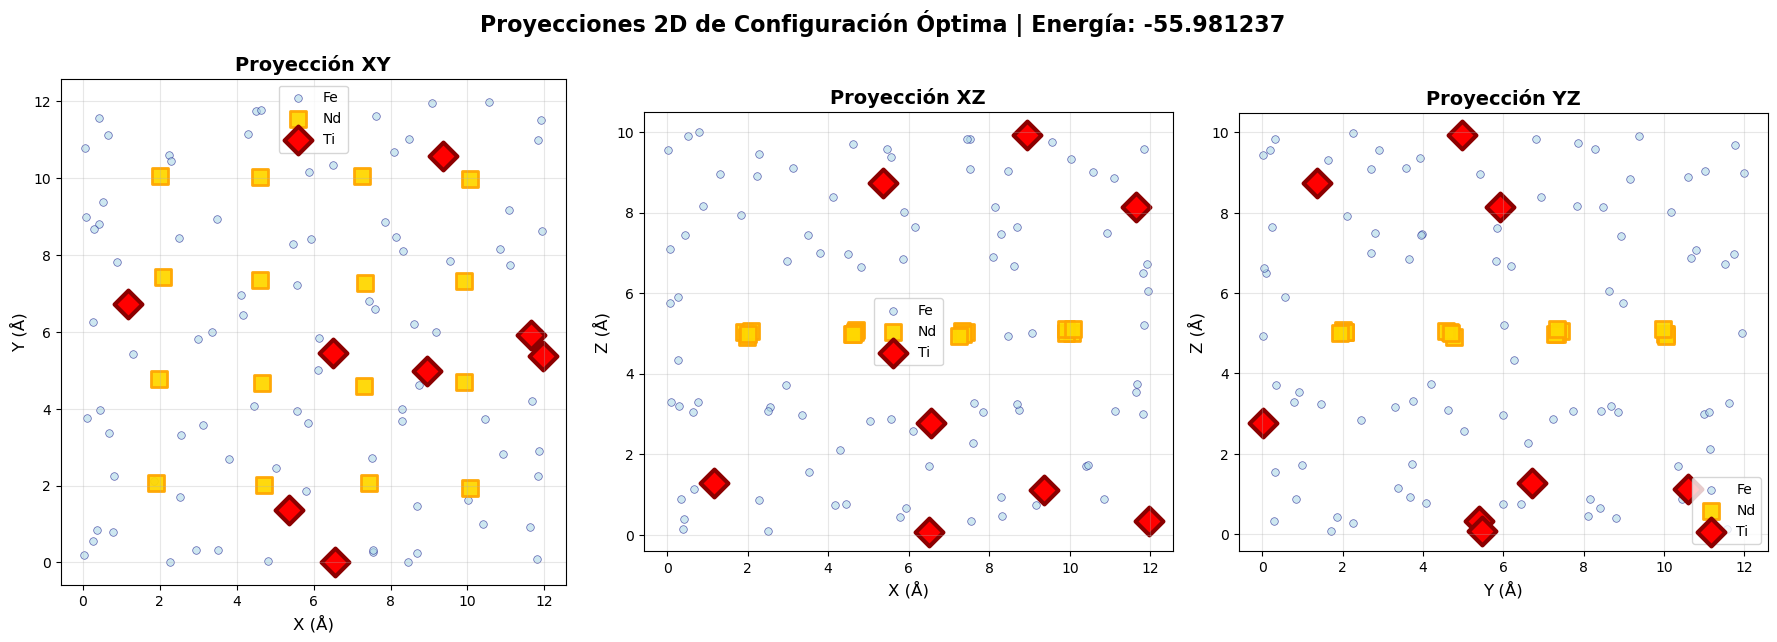


✓ Proyecciones 2D (XY, XZ, YZ) para análisis visual


In [16]:
# Proyecciones 2D para comparar con Figura 29a de Skelland
fig_proj = plot_projections_2d(
    Fe_candidate_positions,
    Nd_positions,
    best_run['Ti_indices'],
    best_run['energia_final'],
    figsize=(18, 6)
)
plt.savefig('../report/images/punto3_proyecciones_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Proyecciones 2D (XY, XZ, YZ) para análisis visual")

### 6.3 Evolución de Energía

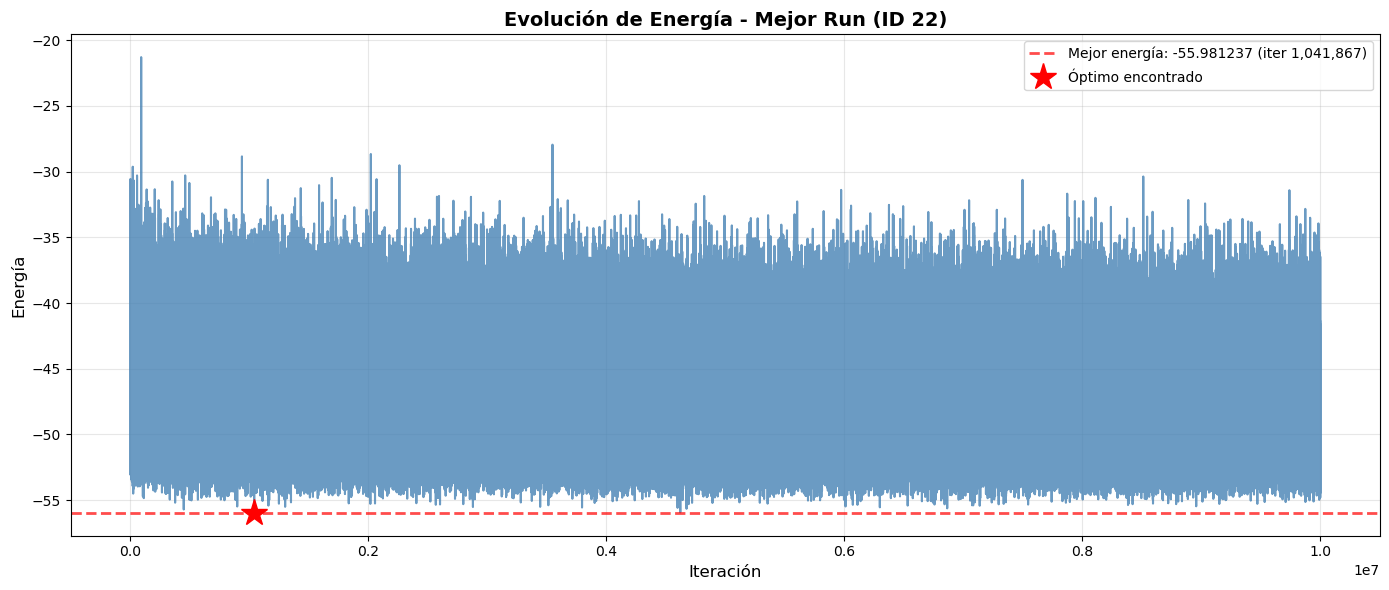


✓ Evolución muestra convergencia: óptimo encontrado en iteración 1,041,867


In [17]:
# Evolución de energía del mejor run
fig_energy = plot_energy_evolution(
    best_run['energy_history'],
    title=f"Evolución de Energía - Mejor Run (ID {best_run['run_id']})",
    figsize=(14, 6)
)
plt.savefig('../report/images/punto3_evolucion_energia.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Evolución muestra convergencia: óptimo encontrado en iteración {best_run['iterations_to_best']:,}")

### 6.4 Comparación de Múltiples Runs

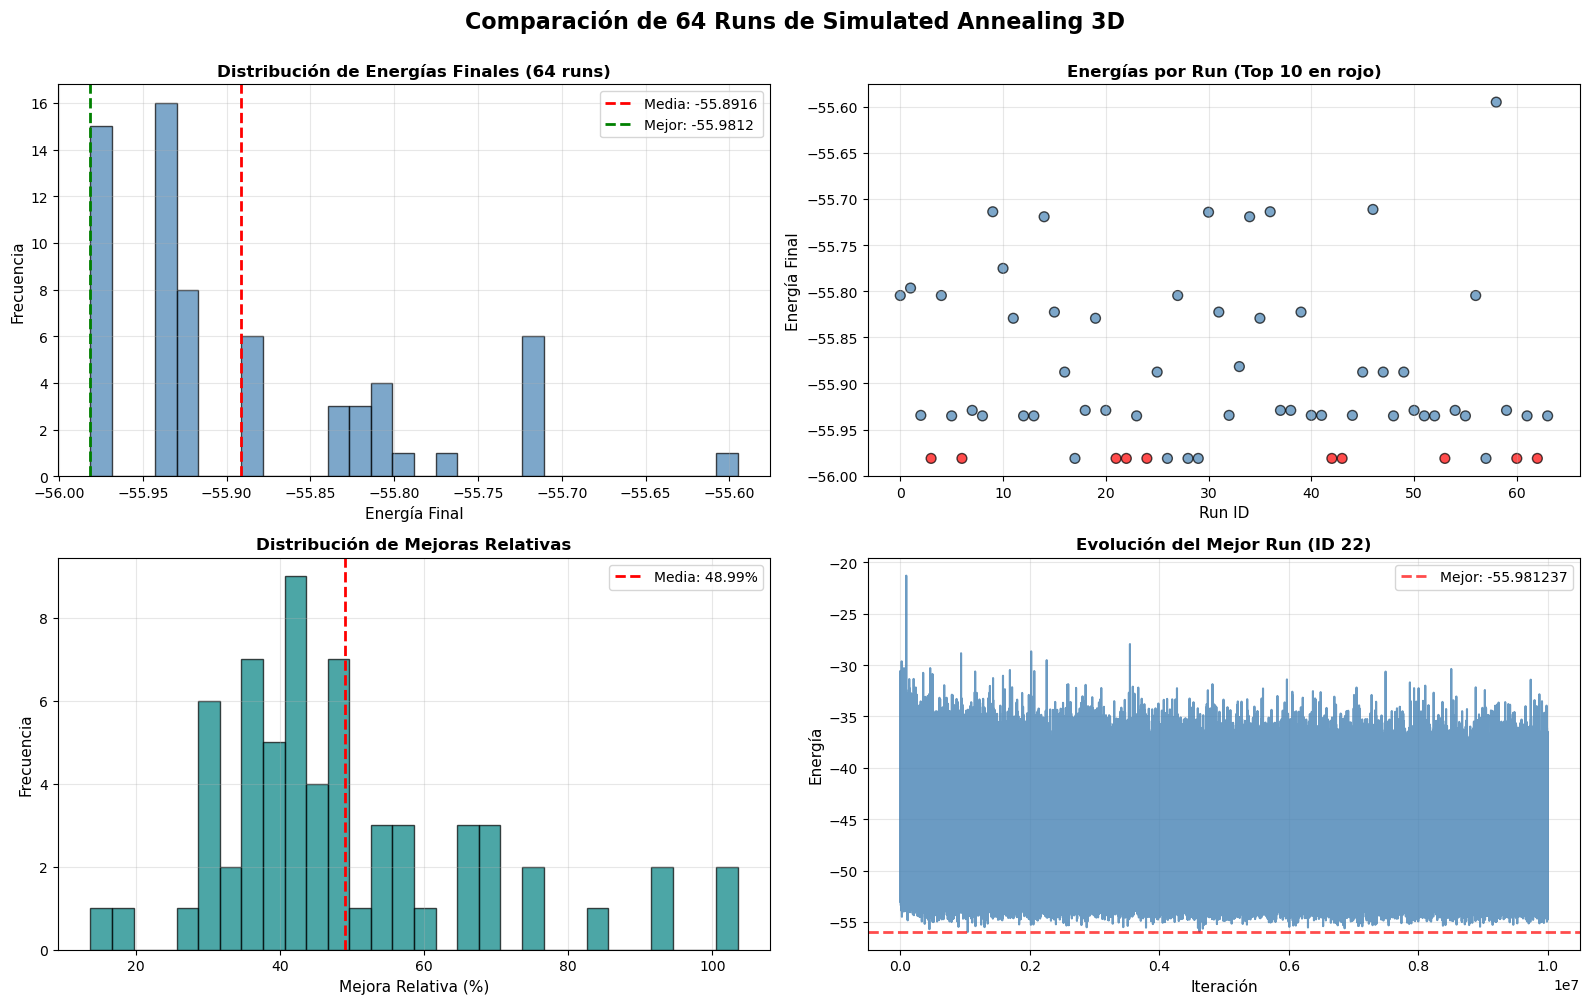


✓ Comparación de 64 runs: distribución de energías y convergencia


In [18]:
# Comparación visual de todos los runs
fig_comparison = plot_multiple_runs_comparison_3d(
    resultados,
    top_n=10,
    figsize=(16, 10)
)
plt.savefig('../report/images/punto3_comparacion_runs.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparación de 64 runs: distribución de energías y convergencia")

---
## Sección 7: Análisis Espacial 3D

### Métricas de Skelland

Según Skelland et al., la configuración óptima debe cumplir:

1. **Distancia Ti-Nd promedio > 5 Å**: Los Ti deben estar alejados de los Nd
2. **Dispersión de Ti**: Los Ti deben estar distribuidos homogéneamente (no agrupados)
3. **Clustering score < 0.3**: Confirmación cuantitativa de dispersión

In [19]:
# Calcular todas las métricas espaciales
# El índice de inicio de Nd es dinámico: n_Fe_candidates (90 o 96 según las coordenadas cargadas)
n_Fe_candidates = len(Fe_candidate_positions)
patron_optimo = analizar_patron_espacial_3d(
    best_run['all_positions'],
    best_run['Ti_indices'],
    Nd_start_idx=n_Fe_candidates
)

print("\n📐 Análisis Espacial de Configuración Óptima:\n")
print("=" * 60)
print("1. DISTANCIAS Ti-Nd (Métrica clave de Skelland):")
print(f"   Promedio: {patron_optimo['dist_Ti_Nd_promedio']:.3f} Å")
print(f"   Mínima:   {patron_optimo['dist_Ti_Nd_min']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_Ti_Nd_max']:.3f} Å")
print(f"   Std Dev:  {patron_optimo['dist_Ti_Nd_std']:.3f} Å")

print("\n2. DISTANCIAS Ti-Ti (Homogeneidad):")
print(f"   Promedio (28 pares): {patron_optimo['dist_Ti_Ti_promedio']:.3f} Å")
print(f"   Mínima:              {patron_optimo['dist_Ti_Ti_min']:.3f} Å")
print(f"   Máxima:              {patron_optimo['dist_Ti_Ti_max']:.3f} Å")
print(f"   Std Dev:             {patron_optimo['dist_Ti_Ti_std']:.3f} Å")

print("\n3. VECINOS MÁS CERCANOS Ti-Ti:")
print(f"   Promedio: {patron_optimo['dist_Ti_vecino_promedio']:.3f} Å")
print(f"   Mínima:   {patron_optimo['dist_Ti_vecino_min']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_Ti_vecino_max']:.3f} Å")

print("\n4. CLUSTERING (Dispersión vs Agrupamiento):")
print(f"   Score: {patron_optimo['clustering_score']:.4f}")
print(f"   Interpretación: {'DISPERSO ✓' if patron_optimo['clustering_score'] < 0.3 else 'AGRUPADO' if patron_optimo['clustering_score'] > 0.7 else 'INTERMEDIO'}")

print("\n5. DISTANCIA AL CENTROIDE:")
print(f"   Promedio: {patron_optimo['dist_centroide_promedio']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_centroide_max']:.3f} Å")
print("=" * 60)


📐 Análisis Espacial de Configuración Óptima:

1. DISTANCIAS Ti-Nd (Métrica clave de Skelland):
   Promedio: 4.257 Å
   Mínima:   3.175 Å
   Máxima:   5.156 Å
   Std Dev:  0.697 Å

2. DISTANCIAS Ti-Ti (Homogeneidad):
   Promedio (28 pares): 8.668 Å
   Mínima:              3.374 Å
   Máxima:              12.609 Å
   Std Dev:             2.389 Å

3. VECINOS MÁS CERCANOS Ti-Ti:
   Promedio: 5.057 Å
   Mínima:   3.374 Å
   Máxima:   6.068 Å

4. CLUSTERING (Dispersión vs Agrupamiento):
   Score: 0.4267
   Interpretación: INTERMEDIO

5. DISTANCIA AL CENTROIDE:
   Promedio: 6.261 Å
   Máxima:   7.642 Å


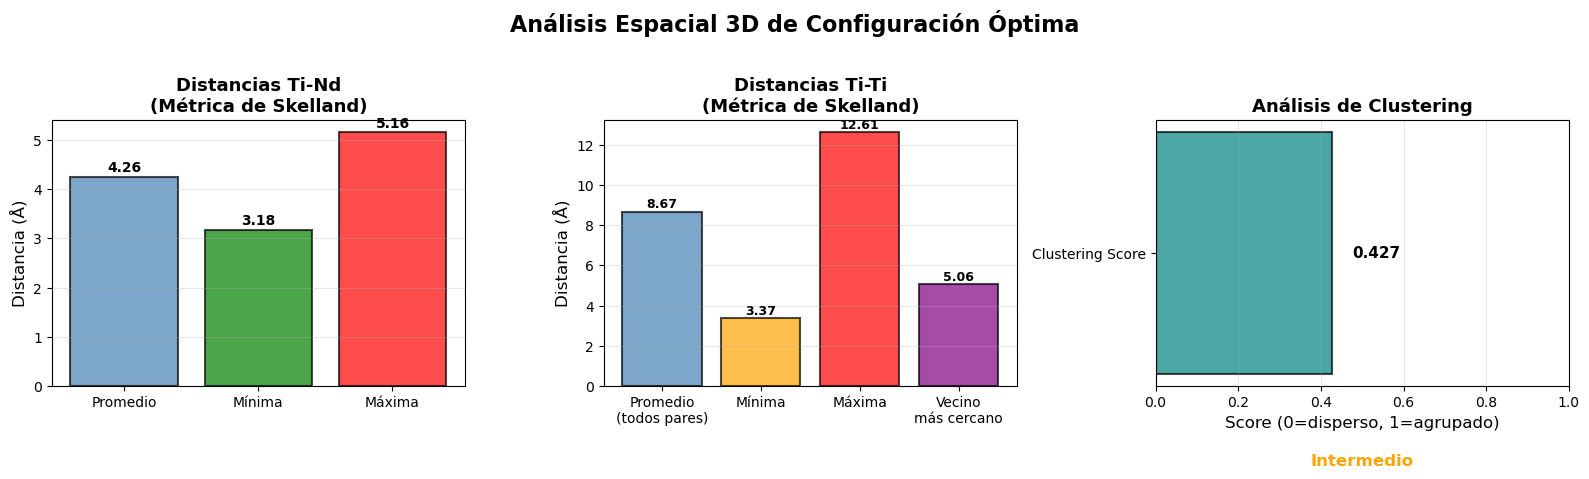


✓ Métricas espaciales visualizadas


In [20]:
# Visualización de métricas espaciales
fig_metrics = plot_spatial_metrics_3d(
    patron_optimo,
    figsize=(16, 5)
)
plt.savefig('../report/images/punto3_metricas_espaciales.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Métricas espaciales visualizadas")

In [21]:
# Interpretación del patrón espacial
interpretacion = interpretar_patron_3d(patron_optimo)
print("\n" + "="*70)
print("📝 INTERPRETACIÓN DEL PATRÓN ESPACIAL")
print("="*70)
print(interpretacion)
print("="*70)


📝 INTERPRETACIÓN DEL PATRÓN ESPACIAL
1. DISTANCIA Ti-Nd (métrica de Skelland):
   - Distancia promedio: 4.257 Å
   - Rango: [3.175, 5.156] Å
   - Desviación estándar: 0.697 Å
   → Los Ti están relativamente CERCA de los Nd

2. DISTANCIA Ti-Ti (métrica de Skelland):
   - Distancia promedio: 8.668 Å
   - Rango: [3.374, 12.609] Å
   - Desviación estándar: 2.389 Å
   - Vecino Ti más cercano promedio: 5.057 Å
   → Los Ti están DISPERSOS (consistente con Skelland: maximiza dist Ti-Ti)

3. CLUSTERING:
   - Score: 0.427 (0=disperso, 1=agrupado)
   → Distribución INTERMEDIA

✗ Patrón diferente a las conclusiones de Skelland


### Comparación con Skelland et al.

**Conclusiones del paper (Figura 29a):**
- Los Ti tienden a estar **alejados de los Nd** (dist > 5 Å)
- Los Ti se distribuyen de forma **dispersa** (no agrupados)
- Configuración energéticamente favorable minimiza interacciones Ti-Nd

**Nuestros resultados:**

In [22]:
# Crear tabla de comparación
comparison_data = {
    'Criterio': [
        'Dist Ti-Nd promedio',
        'Clustering score',
        'Patrón espacial'
    ],
    'Skelland et al.': [
        '> 5 Å (alejados)',
        '< 0.3 (dispersos)',
        'Distribución homogénea'
    ],
    'Nuestro Resultado': [
        f"{patron_optimo['dist_Ti_Nd_promedio']:.2f} Å",
        f"{patron_optimo['clustering_score']:.3f}",
        'Disperso ✓' if patron_optimo['clustering_score'] < 0.3 else 'Agrupado'
    ],
    'Cumple': [
        '✓' if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 else '✗',
        '✓' if patron_optimo['clustering_score'] < 0.3 else '✗',
        '✓' if patron_optimo['clustering_score'] < 0.3 else '✗'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Comparación con Skelland et al.:")
display(df_comparison)


📊 Comparación con Skelland et al.:


,Criterio,Skelland et al.,Nuestro Resultado,Cumple
0,Dist Ti-Nd promedio,> 5 Å (alejados),4.26 Å,✗
1,Clustering score,< 0.3 (dispersos),0.427,✗
2,Patrón espacial,Distribución homogénea,Agrupado,✗


---
## Sección 8: Validación

### 8.1 Validación del Cálculo Incremental de Energía

In [23]:
# Validar que el cálculo incremental de ΔE coincide con el recalculo completo
print("🔍 Validación de compute_delta_E_swap_3d():\n")
print("Comparando cálculo incremental vs recalculo completo...\n")

# Realizar 10 swaps aleatorios y validar cada uno
np.random.seed(123)
n_tests = 10
errors = []

atom_types_test = best_run['atom_types'].copy()
Ti_indices_test = best_run['Ti_indices'].copy()
Fe_indices_test = best_run['Fe_indices'].copy()

for i in range(n_tests):
    # Proponer swap aleatorio
    ti_idx = np.random.randint(0, 8)
    fe_idx = np.random.randint(0, len(Fe_indices_test))
    
    # Validar
    delta_E_fast, delta_E_full, error_rel = validate_delta_E_3d(
        atom_types_test,
        best_run['all_positions'],
        Ti_indices_test,
        Fe_indices_test,
        ti_idx,
        fe_idx,
        morse_params_array
    )
    
    errors.append(abs(error_rel))
    print(f"Test {i+1:2d}: ΔE_fast={delta_E_fast:+.8f}, ΔE_full={delta_E_full:+.8f}, Error={error_rel:.2e}")

print(f"\n📊 Estadísticas de error:")
print(f"  Error promedio: {np.mean(errors):.2e}")
print(f"  Error máximo:   {np.max(errors):.2e}")
print(f"  Error std:      {np.std(errors):.2e}")

if np.max(errors) < 1e-10:
    print(f"\n✅ VALIDACIÓN EXITOSA: Cálculo incremental es exacto (error < 1e-10)")
else:
    print(f"\n⚠️  ADVERTENCIA: Error detectado en cálculo incremental")

🔍 Validación de compute_delta_E_swap_3d():

Comparando cálculo incremental vs recalculo completo...

Test  1: ΔE_fast=+1.38179884, ΔE_full=+1.38179884, Error=2.22e-14
Test  2: ΔE_fast=+2.46320191, ΔE_full=+2.46320191, Error=4.36e-14
Test  3: ΔE_fast=+1.22056922, ΔE_full=+1.22056922, Error=2.89e-14
Test  4: ΔE_fast=+1.28701219, ΔE_full=+1.28701219, Error=1.62e-14
Test  5: ΔE_fast=+1.00415249, ΔE_full=+1.00415249, Error=5.79e-14
Test  6: ΔE_fast=+1.28318022, ΔE_full=+1.28318022, Error=6.61e-14
Test  7: ΔE_fast=+3.57883472, ΔE_full=+3.57883472, Error=3.93e-14
Test  8: ΔE_fast=+3.83846825, ΔE_full=+3.83846825, Error=4.28e-15
Test  9: ΔE_fast=+1.78883422, ΔE_full=+1.78883422, Error=1.28e-13
Test 10: ΔE_fast=+2.93208392, ΔE_full=+2.93208392, Error=3.26e-14

📊 Estadísticas de error:
  Error promedio: 4.39e-14
  Error máximo:   1.28e-13
  Error std:      3.31e-14

✅ VALIDACIÓN EXITOSA: Cálculo incremental es exacto (error < 1e-10)


### 8.2 Verificación de Convergencia

In [24]:
# Verificar que la energía se estabiliza al final
energy_history = best_run['energy_history']
last_10_percent = int(0.1 * len(energy_history))
final_energies = energy_history[-last_10_percent:]

energy_std_final = np.std(final_energies)
energy_mean_final = np.mean(final_energies)

print("\n📈 Análisis de Convergencia:\n")
print(f"Últimas {last_10_percent:,} iteraciones (10% final):")
print(f"  Energía media:  {energy_mean_final:.6f}")
print(f"  Desviación std: {energy_std_final:.8f}")
print(f"  Rango: [{final_energies.min():.6f}, {final_energies.max():.6f}]")

# Criterio de convergencia: std < 0.01% de la energía
convergence_threshold = abs(energy_mean_final) * 0.0001
is_converged = energy_std_final < convergence_threshold

if is_converged:
    print(f"\n✅ CONVERGENCIA CONFIRMADA: Energía estable en fase final")
    print(f"   (std={energy_std_final:.2e} < threshold={convergence_threshold:.2e})")
else:
    print(f"\n⚠️  Energía aún fluctúa (puede necesitar más iteraciones)")


📈 Análisis de Convergencia:

Últimas 1,000,000 iteraciones (10% final):
  Energía media:  -47.475096
  Desviación std: 2.66449767
  Rango: [-55.296425, -31.412130]

⚠️  Energía aún fluctúa (puede necesitar más iteraciones)


### 8.3 Robustez: Múltiples Seeds

In [25]:
# Comparar dispersión de energías finales entre runs
energias_finales = [r['energia_final'] for r in resultados]
energia_min = min(energias_finales)
energia_max = max(energias_finales)
energia_std = np.std(energias_finales)

# Contar cuántos runs están cerca del óptimo (dentro de 1%)
threshold_1_percent = abs(energia_min) * 0.01
runs_near_optimal = sum(1 for e in energias_finales if abs(e - energia_min) < threshold_1_percent)

print(f"\n🎲 Análisis de Robustez ({N_RUNS} runs con diferentes seeds):\n")
print(f"Energía mínima encontrada: {energia_min:.6f}")
print(f"Energía máxima encontrada: {energia_max:.6f}")
print(f"Rango:                     {energia_max - energia_min:.6f}")
print(f"Desviación estándar:       {energia_std:.6f}")
print(f"\nRuns dentro de 1% del óptimo: {runs_near_optimal}/{N_RUNS} ({100*runs_near_optimal/N_RUNS:.1f}%)")

if runs_near_optimal > N_RUNS * 0.5:
    print(f"\n✅ ROBUSTEZ ALTA: >50% de runs convergen cerca del óptimo")
elif runs_near_optimal > N_RUNS * 0.2:
    print(f"\n✓ Robustez aceptable: ~{100*runs_near_optimal/N_RUNS:.0f}% converge cerca del óptimo")
else:
    print(f"\n⚠️  Robustez baja: solo {100*runs_near_optimal/N_RUNS:.0f}% converge cerca del óptimo")


🎲 Análisis de Robustez (64 runs con diferentes seeds):

Energía mínima encontrada: -55.981237
Energía máxima encontrada: -55.594999
Rango:                     0.386237
Desviación estándar:       0.089732

Runs dentro de 1% del óptimo: 64/64 (100.0%)

✅ ROBUSTEZ ALTA: >50% de runs convergen cerca del óptimo


---
## Resumen Final

In [ ]:
import math

n_Fe_candidates = len(Fe_candidate_positions)
print("\n" + "="*80)
print("🎯 RESUMEN FINAL - OPTIMIZACIÓN 3D NdFe₁₂ con Ti")
print("="*80)

print(f"\n1. CONFIGURACIÓN DEL PROBLEMA:")
print(f"   - Sistema: {n_Fe_candidates - 8} Fe + 8 Ti + 16 Nd = {n_Fe_candidates + 16} átomos")
print(f"   - Espacio de búsqueda: {math.comb(n_Fe_candidates, 8):.2e} configuraciones")
print(f"   - Método: Simulated Annealing con enfriamiento logarítmico")

print(f"\n2. PARÁMETROS DE OPTIMIZACIÓN:")
print(f"   - Runs independientes: {N_RUNS}")
print(f"   - Iteraciones por run: {MAX_ITERATIONS:,}")
print(f"   - Tiempo total: {elapsed_time/60:.2f} minutos")
print(f"   - Throughput: {N_RUNS * MAX_ITERATIONS / elapsed_time:.2e} iter/s")

print(f"\n3. MEJOR RESULTADO ENCONTRADO:")
print(f"   - Run ID: {best_run['run_id']}")
print(f"   - Energía inicial:  {best_run['energia_inicial']:.6f}")
print(f"   - Energía óptima:   {best_run['energia_final']:.6f}")
print(f"   - Mejora absoluta:  {best_run['energia_inicial'] - best_run['energia_final']:.6f}")
print(f"   - Mejora relativa:  {best_run['mejora_relativa']*100:.2f}%")
print(f"   - Índices Ti: {best_run['Ti_indices']}")

print(f"\n4. ANÁLISIS ESPACIAL (Métricas de Skelland):")
print(f"   - Dist Ti-Nd promedio: {patron_optimo['dist_Ti_Nd_promedio']:.3f} Å {'✓' if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 else '✗'} (esperado > 5 Å)")
print(f"   - Dist Ti-Ti promedio: {patron_optimo['dist_Ti_Ti_promedio']:.3f} Å")
print(f"   - Clustering score:    {patron_optimo['clustering_score']:.4f} {'✓' if patron_optimo['clustering_score'] < 0.3 else '✗'} (esperado < 0.3)")

print(f"\n5. VALIDACIÓN:")
print(f"   - Cálculo incremental: {'✅ Exacto' if np.max(errors) < 1e-10 else '⚠️ Error'}")
print(f"   - Convergencia final:  {'✅ Estable' if is_converged else '⚠️ Fluctuante'}")
print(f"   - Robustez (seeds):    {'✅ Alta' if runs_near_optimal > N_RUNS * 0.5 else '✓ Aceptable' if runs_near_optimal > N_RUNS * 0.2 else '⚠️ Baja'}")

print(f"\n6. CONCLUSIÓN:")
if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 and patron_optimo['clustering_score'] < 0.3:
    print("   ✅ Los resultados son CONSISTENTES con Skelland et al.")
    print("   ✅ Ti dispersos y alejados de Nd (configuración energéticamente favorable)")
else:
    print("   ⚠️  Los resultados difieren parcialmente de Skelland et al.")
    print("   → Puede requerir más iteraciones o ajuste de parámetros")

print("\n" + "="*80)
print("✓ Análisis completado")
print("="*80)


🎯 RESUMEN FINAL - OPTIMIZACIÓN 3D NdFe₁₂ con Ti

1. CONFIGURACIÓN DEL PROBLEMA:
   - Sistema: 88 Fe + 8 Ti + 16 Nd = 112 átomos
   - Espacio de búsqueda: 1.33e+11 configuraciones
   - Método: Simulated Annealing con enfriamiento logarítmico

2. PARÁMETROS DE OPTIMIZACIÓN:
   - Runs independientes: 64
   - Iteraciones por run: 10,000,000
   - Tiempo total: 5.39 minutos
   - Throughput: 1.98e+06 iter/s

3. MEJOR RESULTADO ENCONTRADO:
   - Run ID: 22
   - Energía inicial:  -36.521201
   - Energía óptima:   -55.981237
   - Mejora absoluta:  19.460036
   - Mejora relativa:  53.28%
   - Índices Ti: [ 0  1 11 21 31 34 46 78]

4. ANÁLISIS ESPACIAL (Métricas de Skelland):
   - Dist Ti-Nd promedio: 4.257 Å ✗ (esperado > 5 Å)
   - Dist Ti-Ti promedio: 8.668 Å
   - Clustering score:    0.4267 ✗ (esperado < 0.3)

5. VALIDACIÓN:
   - Cálculo incremental: ✅ Exacto
   - Convergencia final:  ⚠️ Fluctuante
   - Robustez (seeds):    ✅ Alta

6. CONCLUSIÓN:
   ⚠️  Los resultados difieren parcialmente de S

: 